In [24]:
import numpy as np
import scipy as sc
from iminuit import Minuit
import pandas as pd
import scipy.interpolate as interpolate
from scipy.integrate import quad
from matplotlib import colors
from EBL_fit_MC_functions import *
from scipy.stats import norm
from scipy.stats import poisson
import yaml
import matplotlib.pyplot as plt
import h5py
import time
import sys
import os
import uproot
from scipy.stats import norm, chi2
from pathlib import Path

In [25]:
knots = 2
Emin = 0.06
Emax = 15.

with open("/home/rgrau/Desktop/EBL-splines/EBL_fit_config2_1.yml", "r") as f:
    inp_config = yaml.safe_load(f)
fit_func_name = "MBPWL"
Telescope = inp_config["Telescope"]
Spectrum_func_name = inp_config["Spectrum_func_name"]
EBL_Model = inp_config["EBL_Model"]
Source_flux = inp_config["Source_flux"]
Observation_time = inp_config["Observation_time"]
Background_scale = inp_config["Background_scale"]
Forward_folding = inp_config["Forward_folding"]
Norm = inp_config["Norm"]
Ph_index = inp_config["Ph_index"]
# initial_guess_0 = inp_config["initial_guess_0"] #TODO change to add Efirst and Elast.
LP_curvature = inp_config["LP_curvature"]
Source_z = inp_config["Source_z"]

def fit_func(xdata, params): #for 1 knot
    if knots == 1:
        polw = np.zeros(len(xdata))
        gamma = np.zeros(knots+1)
        phi = np.zeros(knots+1)
        phi_0 = params[0] #len(sqrtdelta_lam) = len(lam)-1 = len(phi)-1
        gamma0 = params[1]
        sqrtdelta_gamma = params[2:knots+2]
        Eknot = params[-1]
        delta_gamma = np.square(sqrtdelta_gamma)
        gamma[0] = gamma0
        phi[0] = phi_0
        gamma[1] = gamma[0] + delta_gamma[0]
        phi[1] = phi[0] * (Eknot/0.25) ** delta_gamma[0]
        for i in range(len(xdata)):
            if xdata[i] < Eknot:
                polw[i] = phi[0] * (xdata[i]/0.25) ** (-gamma[0])
            elif xdata[i] >= Eknot:
                polw[i] = phi[1] * (xdata[i]/0.25) ** (-gamma[1])
        return polw
    else:
        polw = np.zeros(len(xdata))

        gamma = np.zeros(knots+1)
        phi = np.zeros(knots+1)
        phi_0 = params[0] #len(sqrtdelta_lam) = len(lam)-1 = len(phi)-1
        gamma0 = params[1]
        sqrtdelta_gamma = params[2:knots+2]
        Efirst = params[-2]
        DeltaElast = params[-1]
        Elast = Efirst + DeltaElast
        Ebr = np.geomspace(Efirst, Elast, knots)
        delta_gamma = np.square(sqrtdelta_gamma)
        gamma[0] = gamma0
        phi[0] = phi_0
        for i in range(knots):
            gamma[i+1] = gamma[i] + delta_gamma[i]
            phi[i+1] = phi[i] * (Ebr[i]/0.25) ** delta_gamma[i]
        for i in range(len(xdata)):
            for j in range(knots):
                if xdata[i]<Ebr[0]:
                    polw[i] = phi[0] * (xdata[i]/0.25) ** (-gamma[0])
                elif Ebr[-1] < xdata[i]:
                    polw[i] = phi[-1] * (xdata[i]/0.25) ** (-gamma[-1])
                elif Ebr[j] <= xdata[i] < Ebr[j+1]:
                    polw[i] = phi[j+1] * (xdata[i]/0.25) ** (-gamma[j+1])
        return polw

if Telescope == "CTAN_alpha": #this part needs to be changed to include the real CTAN_alpha configuration
    Nwobbles = 5
    def m2LogL(params):
        xdata = E_EBL
        mtau = -tau
        mu_gam0 = dNdE_to_mu((fit_func(xdata, params) * np.exp(mtau * alpha))[2:37], Effa_reb, Ebinsw[2:37], Observation_time, Ebins, Eres_reb2, E_EBL[2:37])
        mu_gam = mu_gam0[5:-4]
        mu_bg = mu_BG(mu_gam, Non, Noff, Nwobbles)
        min_num_gauss = 20
        conditions = [((Non >= min_num_gauss) & (Noff >= min_num_gauss)), (Non == 0.), (Noff == 0.), (Non != 0.) & (Noff != 0.)]
        choices = [Gauss_logL(Non, Noff, mu_gam, Nwobbles), Poisson_logL_Non0(Non, Noff, mu_gam, Nwobbles), Poisson_logL_Noff0(Non, Noff, mu_gam, Nwobbles), Poisson_logL(Non, Noff, mu_gam, mu_bg, Nwobbles)]
        res = np.select(conditions, choices, default = 999999999)
        return np.sum(res)
        
elif Telescope == "MAGIC":
    Nwobbles = 4
    def m2LogL(params):
        xdata = Etrue
        mtau = -tau
        mu_gam = dNdE_to_mu_MAGIC(fit_func(xdata, params), Ebinsw_Etrue, migmatval, Eest)
        mu_gam_final = mu_gam[minbin:maxbin]
        Non_final = Non[minbin:maxbin] 
        Noff_final = Noff[minbin:maxbin]
        mu_bg = mu_BG(mu_gam, Non, Noff, Nwobbles)
        mu_bg_final = mu_bg[minbin:maxbin]
        min_num_gauss = 20
        conditions = [((Non_final >= min_num_gauss) & (Noff_final >= min_num_gauss)), (Non_final == 0.), (Noff_final == 0.), (Non_final != 0.) & (Noff_final != 0.)]
        choices = [Gauss_logL(Non_final, Noff_final, mu_gam_final, Nwobbles), Poisson_logL_Non0(Non_final, Noff_final, mu_gam_final, Nwobbles), Poisson_logL_Noff0(Non_final, Noff_final, mu_gam_final, Nwobbles), Poisson_logL(Non_final, Noff_final, mu_gam_final, mu_bg_final, Nwobbles)]
        res = np.select(conditions, choices, default = 999999999)
        return np.sum(res)

def fit(initial_guess):
    
    m2LogL.errordef = Minuit.LIKELIHOOD
    m = Minuit(m2LogL, initial_guess)
    MBPWL_limits = ([(1e-6, 1e-3), (-4., 5.)])
    errors = [1e-7, 0.01]
    for i in range(knots):
        MBPWL_limits.append((None, None))
        errors.append(0.001)
    if knots == 1:
        MBPWL_limits.append((0.08, 4.0))
        errors.append(0.01)
    else:
        MBPWL_limits.append((None, 0.4))
        MBPWL_limits.append((0., None))
        errors.append(0.001)
        errors.append(0.001)
    m.limits = MBPWL_limits
    # m.tol = 1e-6 #this improves slightly the chi2
    # m.strategy = 2
    # m.errors = errors #errors do not work well here for more than 1 knot

    m.migrad()
    return m
if EBL_Model == "Dominguez": #loads the EBL data of the Dominguez et al 2011 paper.
    file = np.loadtxt('/home/rgrau/Desktop/EBL-splines/tau_dominguez11.out')
    pdfile = pd.DataFrame(file)
    pdfile = pdfile.rename(columns={ 0 : 'E [TeV]', 1: 'tau z=0.01', 2: 'tau z=0.02526316', 3: 'tau z=0.04052632', 4: 'tau z=0.05578947', 5: 'tau z=0.07105263', 6: 'tau z=0.08631579', 7: 'tau z=0.10157895', 8: 'tau z=0.11684211', 9: 'tau z=0.13210526', 10: 'tau z=0.14736842', 11: 'tau z=0.16263158', 12: 'tau z=0.17789474', 13: 'tau z=0.19315789', 14: 'tau z=0.20842105'})
    E_EBL = pdfile['E [TeV]'].to_numpy() #energy bins
    tau_EBL = pdfile['tau z=0.20842105'].to_numpy() #tau bins
else:
    raise Exception('The EBL model "{func}" has not been implemented.'.format(func = EBL_Model))

if Spectrum_func_name == "PWL": #define the intrinsic spectrum if the function is a Power-Law
    def dNdE_absorbed(K, E, Norm, Ph_index, tau):
        dNdE = K / ((E/Norm)**Ph_index)
        m_tau = -tau
        return dNdE * np.exp(m_tau)

elif Spectrum_func_name == "LP": #define the intrinsic spectrum if the function is a Log-Parabola
    def dNdE_absorbed(K, E, Norm, Ph_index, b, tau):
        dNdE = K / ((E/Norm)**(Ph_index + (b * np.log(E/Norm))))
        m_tau = -tau
        return dNdE * np.exp(m_tau)

else:
    raise Exception('The simulated spectrum "{func}" has not been implemented.'.format(func = Spectrum_func_name))


In [26]:
if Telescope == "CTAN_alpha": #compute the values we need if the telescope selected is CTAN_alpha (needs to be changed as the Response function has to be changed)
    #Effective area:
    fileEA = np.loadtxt('/home/rgrau/Desktop/EBL-splines/EffArea50h.txt', skiprows = 11)
    EffA = pd.DataFrame(fileEA)
    EffA = EffA.rename(columns={ 0 : 'E [TeV]', 1: 'Eff area (m^2)'})
    EffaE= EffA['E [TeV]'].to_numpy()
    Effa = EffA['Eff area (m^2)'].to_numpy()

    Effa_reb = normal_interp1d(EffaE, Effa, E_EBL[2:37])


    #Anglular resolution:
    fileAng = np.loadtxt('/home/rgrau/Desktop/EBL-splines/Angres.txt', skiprows = 11)
    Angresall = pd.DataFrame(fileAng)
    Angresall = Angresall.rename(columns={ 0 : 'E [TeV]', 1: 'Angular resolution (deg)'})
    AngresE = Angresall['E [TeV]'].to_numpy()
    Angres = Angresall['Angular resolution (deg)'].to_numpy()
    logE = np.log10(E_EBL)

    Angres_reb = log_interp1d(AngresE, Angres, E_EBL[2:37])

    #Background:
    fileBkg = np.loadtxt('/home/rgrau/Desktop/EBL-splines/Bkg50h.txt', skiprows = 10)
    Bkgpd = pd.DataFrame(fileBkg)
    Bkgpd = Bkgpd.rename(columns={ 0 : 'E_min (TeV)', 1: 'E_max (TeV)', 2: 'Bck Rate (Hz/deg^2)'})

    BckgEmin = Bkgpd['E_min (TeV)'].to_numpy()
    BckgEmax = Bkgpd['E_max (TeV)'].to_numpy()
    Bckg = Bkgpd['Bck Rate (Hz/deg^2)'].to_numpy()
    BckgEdiff = BckgEmax - BckgEmin

    BckgElogmean = np.power(10 ,np.mean([np.log10(BckgEmax), np.log10(BckgEmin)], axis = 0))

    Ebinsmin = np.zeros(len(E_EBL))
    Ebinsmax = np.zeros(len(E_EBL))

    for i in range(1, len(E_EBL)):
        Ebinsmin[i] = 10**(np.mean([np.log10(E_EBL[i]), np.log10(E_EBL[i-1])]))
    for i in range(len(E_EBL) - 1):
        Ebinsmax[i] = 10**(np.mean([np.log10(E_EBL[i]), np.log10(E_EBL[i+1])]))
        
    Ebinsmin[0] = 10**(np.log10(Ebinsmin[1])-(np.log10(Ebinsmin[2])-np.log10(Ebinsmin[1])))
    Ebinsmax[len(E_EBL)-1] = 10**(np.log10(Ebinsmax[len(E_EBL)-2])-(np.log10(Ebinsmax[len(E_EBL)-3])-np.log10(Ebinsmax[len(E_EBL)-2])))
    Ebinsw = Ebinsmax - Ebinsmin
    DifBckg = Bckg / (BckgEmax - BckgEmin) #Hz/deg**2

    interpolation_bckg = log_interp1d2(BckgElogmean,DifBckg)

    Bckg_reb = np.zeros([len(E_EBL[2:37]),2])
    for i in range(len(E_EBL[2:37])):
        Bckg_reb[i] = quad(interpolation_bckg, Ebinsmin[i+2], Ebinsmax[i+2])
    Bckg_reb = Bckg_reb[:,0]

    #Treating the data:
    skyang = (180/np.pi)**2 * 2 * np.pi * (1-np.cos(np.deg2rad(Angres_reb)))#deg^2
    bckgmu = Bckg_reb * Observation_time * skyang

    ##Generating dNdE_absorved and applying Eres to it
    if Spectrum_func_name == "PWL":
        dNdEa = dNdE_absorbed(Source_flux, E_EBL, Norm, Ph_index, tau_EBL)

    elif Spectrum_func_name == "LP":
        dNdEa = dNdE_absorbed(Source_flux, E_EBL, Norm, Ph_index, LP_curvature, tau_EBL)
    
    
    logEbins = np.zeros(len(E_EBL[2:37])+1)
    for i in range(len(E_EBL[2:37])+1):
        if i == 0:
            logEbins[i] = logE[2] - ((logE[3]-logE[2])/2)
        elif i == (len(E_EBL[2:37])):
            logEbins[i] = logE[2:37][i-1] + ((logE[2:37][i-1]-logE[2:37][i-2])/2)
        else:
            logEbins[i] = (logE[2:37][i] + logE[2:37][i-1]) / 2

    Ebins = 10 ** logEbins
    #Energy Resolution:

    # if Energy_migration:

    #     fileEres = np.loadtxt('/home/rgrau/Desktop/EBL-splines/Eres.txt', skiprows = 8)
    #     Eresall = pd.DataFrame(fileEres)
    #     Eresall = Eresall.rename(columns={ 0 : 'E [TeV]', 1: 'Energy resolution (deg)'})
    #     EresE = Eresall['E [TeV]'].to_numpy()
    #     Eres = Eresall['Energy resolution (deg)'].to_numpy()

    #     Eres_reb = log_interp1d(EresE[:-1], Eres[:-1], E_EBL[2:37])
    #     Eres_reb2 = Eres_reb * E_EBL[2:37]
        
    #     mu_vec_reco = dNdE_to_mu(dNdEa[2:37], Effa_reb, Ebinsw[2:37], Observation_time, Ebins, Eres_reb2, E_EBL[2:37])
    # else:
    mu_vec_reco = dNdEa[2:37] * Effa_reb * Ebinsw[2:37] * Observation_time

    E_final = E_EBL[7:33] #[7:33]
    mu_vec_final = mu_vec_reco[5:-4] #[5:-4]
    bckgmu_final = bckgmu[5:-4] * Background_scale
    Effa_final = Effa_reb[5:-4]
    Ebinsw_final = Ebinsw[7:33]
    tau = tau_EBL[7:33]

elif Telescope == "MAGIC": #compute values needed for minimization if the selected telescope is MAGIC
    
    Bckg = uproot.open("/home/rgrau/Desktop/EBL-splines/Output_flute.root:hEstBckgE")#load background values
    bckgmu_final = Bckg.values() #counts in 42480s (can be normalized for any time but as the migmatrix is for that time, only use that time).

    migrmatrix = uproot.open("/home/rgrau/Desktop/EBL-splines/fold_migmatrix.root:mig_matrix") #load migration matrix
    migmatval = migrmatrix.values() #m^2 * s #values
    migmatxEtrue = migrmatrix.axis("x").edges()/1e3 #TeV #edge values of X axis of the migration matrix (True Energy)
    migmatyEest = migrmatrix.axis("y").edges()/1e3 #TeV #edge values of Y axis of the migration matrix (Estimated Energy)

    Eest = migrmatrix.axis("y").centers()/1e3 #TeV #center values of X axis of the migration matrix (True Energy)
    Etrue = migrmatrix.axis("x").centers()/1e3 #TeV #center values of Y axis of the migration matrix (Estimated Energy)
    E_final = Etrue
    Usedbins = np.where((Emin <= Eest) & (Eest <= Emax))
    minbin = Usedbins[0][0]
    maxbin = Usedbins[0][-1] + 1
    Eest_final = Eest[minbin:maxbin]
    
    tau = tau_interp(Etrue, Source_z, EBL_Model, kind_of_interp = "log") #interpolate the tau values to have the same bins as the migration matrix and the data.
    Ebinsw_final = migmatyEest[1:] - migmatyEest[:-1] #compute the bin width of the final energy bins
    Ebinsw_Etrue = migmatxEtrue[1:] - migmatxEtrue[:-1] #compute the bin width of Etrue energy bins

    if Spectrum_func_name == "PWL":
        dNdEa = dNdE_absorbed(Source_flux, Etrue, Norm, Ph_index, tau) #use the previously defined dNdE function 

    elif Spectrum_func_name == "LP":
        dNdEa = dNdE_absorbed(Source_flux, Etrue, Norm, Ph_index, LP_curvature, tau) #use the previously defined dNdE function 

    mu_vec_final = dNdE_to_mu_MAGIC(dNdEa, Ebinsw_Etrue, migmatval, Eest) #get the dNdE to the needed mu values for the likelihood.

else:
    raise Exception('The telescope "{func}" has not been implemented.'.format(func = Telescope))

xdata = E_final

In [27]:
# mu_vec_final

In [28]:
if knots == 1:
    initial_guess_0 = np.array((5e-6, 2.0, 0.0, 0.1))
else:
    initial_guess_0 = np.zeros(knots + 4)
    initial_guess_0[0] = 8e-6
    initial_guess_0[1] = 2.0
    initial_guess_0[-1] = 0.1
    initial_guess_0[-2] = 0.1

In [29]:
# def process2(mu_on, mu_off):
#         global alpha, Non, Noff
#         Non, Noff = np.round(mu_on), np.round(Nwobbles * mu_off)
#         Non_u, Noff_u = np.sqrt(Non), np.sqrt(Noff)
#         things = fit(initial_guess=initial_guess_0)
#         chi2 = m2LogL(things.values)
#         # print(Non.astype("float"), mu_on, Noff.astype("float"), Nwobbles * mu_off)
#         return chi2, things.values
def process2(mu_on, mu_off):
    global Non, Noff
    Non, Noff = np.round(mu_on), np.round(Nwobbles * mu_off)
    Non_u, Noff_u = np.sqrt(Non), np.sqrt(Noff)
    things = fit(initial_guess=initial_guess_0)
    if things.valid == False:
        raise Warning("The minimum is not valid")
    chi2 = m2LogL(things.values)
    return chi2, things.values



mu_on = mu_vec_final + bckgmu_final
mu_off = bckgmu_final 
chis, fit_results = process2(mu_on, mu_off)
print(fit_results, chis)

/home/rgrau/Desktop/EBL-splines/EBL_fit_MC_functions.py:297: RuntimeWarning: divide by zero encountered in true_divide
  return np.square(diff)/np.square(delta_diff)
/home/rgrau/Desktop/EBL-splines/EBL_fit_MC_functions.py:278: RuntimeWarning: divide by zero encountered in log
  logL = np.log(poisson.pmf(Non, mu_gam + mu_bg) * poisson.pmf(Noff, Nwobbles * mu_bg)) #change this to sum of logs.(and maybie add gaussian)
/tmp/ipykernel_21008/3693366311.py:58: RuntimeWarning: invalid value encountered in double_scalars
  phi[i+1] = phi[i] * (Ebr[i]/0.25) ** delta_gamma[i]
/home/rgrau/Desktop/EBL-splines/EBL_fit_MC_functions.py:297: RuntimeWarning: invalid value encountered in true_divide
  return np.square(diff)/np.square(delta_diff)


Warning: The minimum is not valid

In [ ]:
if knots == 1:
    Ebreaks = fit_results[-1]
else:
    Ebreaks = np.geomspace(fit_results[knots + 2], fit_results[knots + 2] + fit_results[knots + 3], knots)
print(Ebreaks)

[0.1 0.2]


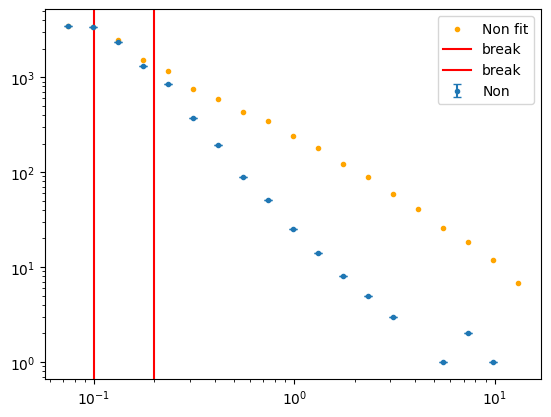

In [ ]:
E_forplot = Eest[minbin:maxbin]
mu_gam = dNdE_to_mu_MAGIC((fit_func(E_final, fit_results)), Ebinsw_Etrue, migmatval, Eest)
mu_gam_final = mu_gam[minbin:maxbin]
mu_bg = mu_BG(mu_gam, Non, Noff, Nwobbles)
mu_bg_final = mu_bg[minbin:maxbin]
mu_on_sim = mu_gam_final + mu_bg_final

plt.errorbar(E_forplot, Non[minbin:maxbin], yerr=0, fmt = ".", label = "Non", capsize = 3)
plt.scatter(E_forplot, mu_on_sim, marker = ".", label = "Non fit", color = 'orange')
# plt.axvline(fit_results[3])
if knots == 1:
    plt.axvline(Ebreaks, label = "break", color = "red")
else:
    for i in range(knots):
        plt.axvline(Ebreaks[i], label = "break", color = "red")
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

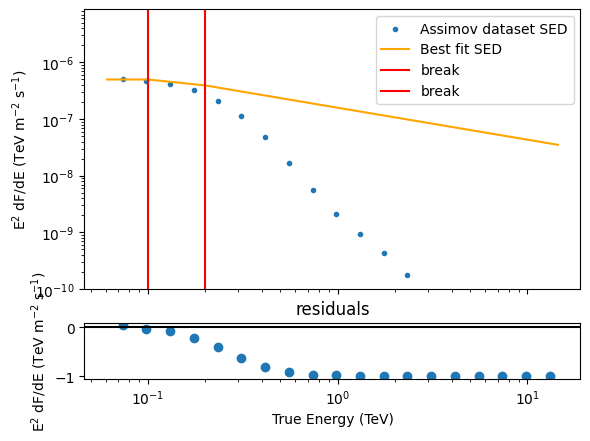

In [ ]:
tau = tau_interp(Eest_final, Source_z, EBL_Model, kind_of_interp = "log")#log_interp1d(E_EBL, tau_EBL, Eest_final)
if Spectrum_func_name == 'PWL':
    SED_orig = dNdE_absorbed(Source_flux, Eest_final, Norm, Ph_index, tau) * Eest_final * Eest_final
elif Spectrum_func_name == 'LP':
    SED_orig = dNdE_absorbed(Source_flux, Eest_final, Norm, Ph_index, LP_curvature, tau) * Eest_final * Eest_final
# SED_orig = dNdEa * Etrue * Etrue
# Etrue
SED_fit = fit_func(Etrue, fit_results) * Etrue * Etrue
SED_fit2 = fit_func(Eest_final, fit_results) * Eest_final * Eest_final
binw = np.zeros(len(Eest)-1)
# for i in range(len(Eest)-1):
#     binw = Eest[i+1] - Eest[i]
# SED_orig_u = (np.sqrt(mu_gam) / 42800 / binw / )[9:24]
Etrue_bins = np.where((Emin <= Etrue) & (Etrue <= Emax))
minbin_tr = Etrue_bins[0][0]
maxbin_tr = Etrue_bins[0][-1] + 1


f, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [5, 1]}, sharex=True)
ax1.scatter(Eest_final, SED_orig, marker = ".", label = "Assimov dataset SED")
# ax1.errorbar(Eest_final, SED_orig, yerr=SED_orig_u, fmt = ".", label = "Assimov dataset SED")
ax1.plot(Etrue[minbin_tr:maxbin_tr], SED_fit[minbin_tr:maxbin_tr], label = "Best fit SED", color = 'orange')
if knots == 1:
    ax1.axvline(Ebreaks, label = "break", color = "red")
else:
    for i in range(knots):
        ax1.axvline(Ebreaks[i], label = "break", color = "red")
ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xlabel("True Energy (TeV)")
ax1.set_ylabel(r"E$^2$ dF/dE (TeV m$^{-2}$ s$^{-1}$)")
ax1.legend()
ax1.set_ylim(bottom = 1e-10)
ax2.scatter(Eest_final, (SED_orig - SED_fit2)/SED_fit2)
ax2.axhline(color = "black")
ax2.set_title("residuals")
ax2.set_ylabel(r"E$^2$ dF/dE (TeV m$^{-2}$ s$^{-1}$)")
# ax2.set_yscale('log')
plt.show()
# plt.scatter(Eest_final, SED_orig, marker = ".", label = "Assimov dataset SED")
# plt.plot(Etrue[37:94], SED_fit[37:94], label = "Best fit SED", color = 'orange')
# # plt.axvline(fit_results[3])
# if knots == 1:
#     plt.axvline(Ebreaks, label = "break", color = "red")
# else:
#     for i in range(knots):
#         plt.axvline(Ebreaks[i], label = "break", color = "red")
# plt.yscale('log')
# plt.xscale('log')
# plt.xlabel("True Energy (TeV)")
# plt.ylabel(r"E$^2$ dF/dE (TeV m$^{-2}$ s$^{-1}$)")
# plt.legend()
# plt.show()

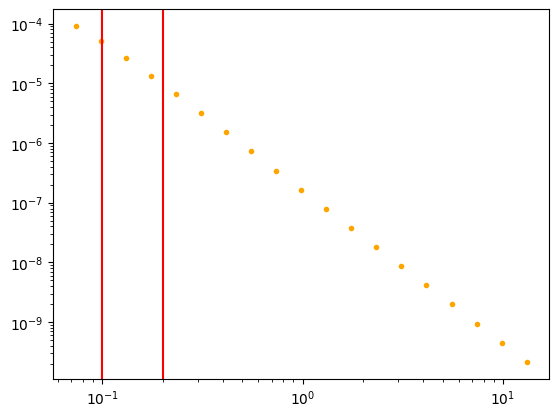

In [ ]:
plt.scatter(E_forplot, fit_func(E_forplot, fit_results), marker = ".", label = "Non fit", color = 'orange')
if knots == 1:
    plt.axvline(Ebreaks, label = "break", color = "red")
else:
    for i in range(knots):
        plt.axvline(Ebreaks[i], label = "breaks", color = "red")
plt.yscale('log')
plt.xscale('log')
plt.show()

Amb 1ES1011:

1 Knot: x3=0.27224112265007755> 1.7059327959311237

2 knots: x4=0.17145978706869028 x5=0.3299753302773061> 0.5107215439677744

3 knots: x5=0.17178851884818816 x6=0.6347962344078829> 0.5107225556871701

4 knots: x6=0.16901784927111593 x7=0.4655645335553198> 0.5089859159226218

5 knots: x7=0.17208600642797267 x8=2.326379427921372> 0.5109901427451295

6 knots: x8=0.17065545651791564 x9=0.8950214301216063> 0.5099298574500497


In [ ]:
# if knots == 1:
#     names = ("phi0", "gamma0", "Deltag0", "Eknot")
# else:
#     names = ("phi0", "gamma0")
#     for i in range(knots):
#         names = names + ("Deltag{0}".format(i),)
#     names = names + ("Efirst",)
#     names = names + ("DeltaE",)
# m2LogL.errordef = Minuit.LIKELIHOOD
# m = Minuit(m2LogL, initial_guess_0, name = names)
# MBPWL_limits = ([(1e-6, 1e-3), (-4., 5.)])
# for i in range(knots):
#     MBPWL_limits.append((-4., 4.))
# if knots == 1:
#     MBPWL_limits.append((0.08, 4.0))
# else:
#     MBPWL_limits.append((0.008, 4.))
#     MBPWL_limits.append((0.008, 4.))
# m.limits = MBPWL_limits
# # m.fixed["Efirst"] = True
# # m.fixed["Elast"] = True
# m.errordef = 1
# # m.get_param_states()

In [ ]:
# m.migrad()

In [ ]:
# m.minos()

In [ ]:
# m.draw_mncontour("Efirst", "DeltaE", cl = (0.6827, 0.9545, 0.9973));  # nsigma=4 says: draw four contours from sigma=1 to 4

In [ ]:
# m.draw_profile("Efirst")

Real data MRK421 example

In [ ]:
# Data_mrk421 = uproot.open("/home/rgrau/Desktop/EBL_Gamma2016/EBL_samples/Mrk421_20130415c/data/nominal/flute/Output_flute.root:DiffEspectrum")#("/data/magic/users-ifae/rgrau/EBL-splines/Output_flute.root:hEstBckgE")#load background values
# mrk421_idk = Data_mrk421.values()
# dNdE_mrk421 = mrk421_idk[1]
# Eest_mrk421 = mrk421_idk[0] 
# SED_mrk421 = Eest_mrk421 * Eest_mrk421 * dNdE_mrk421 * 1e-6

In [ ]:
# plt.scatter(Eest_mrk421, SED_mrk421)
# plt.xscale('log')
# plt.yscale('log')